In [2]:
import geopandas as gpd
from rasterstats import zonal_stats   
import pandas as pd
import glob
import re
from tqdm import tqdm

In [3]:
tifs = glob.glob( r"C:\Users\dskcy\UEInfo\TROPOMI_EXTRACTS\data\AllIndia_NO2_tifs\*.tif") + \
        glob.glob( r"C:\Users\dskcy\UEInfo\TROPOMI_EXTRACTS\data\AllIndia_SO2_tifs\*.tif") + \
        glob.glob( r"C:\Users\dskcy\UEInfo\TROPOMI_EXTRACTS\data\AllIndia_HCHO_tifs\*.tif") + \
        glob.glob( r"C:\Users\dskcy\UEInfo\TROPOMI_EXTRACTS\data\AllIndia_O3_tifs\*.tif")

In [102]:
tifs = glob.glob( r"C:\Users\dskcy\UEInfo\TROPOMI_EXTRACTS\data\aod\*.tif")
tifs

['C:\\Users\\dskcy\\UEInfo\\TROPOMI_EXTRACTS\\data\\aod\\AOD_2019.tif',
 'C:\\Users\\dskcy\\UEInfo\\TROPOMI_EXTRACTS\\data\\aod\\AOD_2020.tif',
 'C:\\Users\\dskcy\\UEInfo\\TROPOMI_EXTRACTS\\data\\aod\\AOD_2021.tif',
 'C:\\Users\\dskcy\\UEInfo\\TROPOMI_EXTRACTS\\data\\aod\\AOD_2022.tif',
 'C:\\Users\\dskcy\\UEInfo\\TROPOMI_EXTRACTS\\data\\aod\\AOD_2023.tif']

In [103]:
gdf = gpd.read_file(r"C:\Users\dskcy\UEInfo\TROPOMI_EXTRACTS\assets\india_gis_agroclimatic_zones\india_agroclimatic_zones.shp")

In [104]:
gdfs = []
for tif in tqdm(tifs):
    dummy_gdf = gdf.copy()
    #date = re.findall(r'\d{4}-\d{2}-\d{2}',tif)[0]
    date = re.findall(r'\d{4}',tif)[0]
    pollutant = 'aod'#re.findall(r'INDIA_yearlyavg_(.*?)_\d{4}-\d{2}-\d{2}', tif)[0]
    
    dummy_gdf['mean'.format(pollutant)] = pd.DataFrame(
        zonal_stats(
            vectors=dummy_gdf['geometry'], 
            raster=tif, 
            stats='mean'
        ))['mean']

    dummy_gdf['date'] = date
    dummy_gdf['pollutant'] = pollutant
    gdfs.append(dummy_gdf)

100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


In [105]:
master = pd.concat(gdfs)
master

,objectid,airshednam,airshednum,geometry,mean,date,pollutant
0,1,desert,11,"POLYGON ((76.10105 28.14719, 76.09610 28.13912...",-0.472436,2019,aod
1,2,himal_west,1,"POLYGON ((74.71460 37.07208, 74.71850 37.06276...",-0.807081,2019,aod
2,3,plate_south,10,"POLYGON ((78.34088 19.88362, 78.35133 19.88184...",-1.104490,2019,aod
3,4,igp_upper,4,"POLYGON ((77.59785 30.40388, 77.59956 30.40312...",-0.775090,2019,aod
4,5,coast_gujar,12,"MULTIPOLYGON (((72.65792 21.47014, 72.65792 21...",-0.679079,2019,aod
...,...,...,...,...,...,...,...
10,11,igp_middle,5,"POLYGON ((88.24318 26.44920, 88.24992 26.44919...",-0.133783,2023,aod
11,12,igp_lower,6,"MULTIPOLYGON (((88.34004 26.48699, 88.33995 26...",-0.266005,2023,aod
12,13,coast_east,14,"MULTIPOLYGON (((87.19296 21.96155, 87.19969 21...",-0.504951,2023,aod
13,14,igp_trans,3,"POLYGON ((75.41270 32.32678, 75.43025 32.32474...",0.027057,2023,aod


In [127]:
pivot_table = pd.pivot_table(master, 
                             values=['mean'], 
                             index=['airshednum','date'], 
                             columns=['pollutant'], 
                             )
pivot_table.columns = pivot_table.columns.droplevel(0)

pivot_table = pivot_table.reset_index()
pivot_table['year'] = pivot_table['date'].str[:4]
pivot_table.drop('date',axis=1, inplace=True)

In [128]:
pivot_table['aod'] = pivot_table['aod']

In [129]:
pivot_table.merge(gdf[['airshednam','airshednum']],on='airshednum').to_csv('Regionalairshed_UVAI_means_yearly.csv', index=False)

# Choropleths

In [80]:
import pandas as pd
import geopandas as gpd
import numpy as np

import jenkspy
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


In [81]:
pollutant = 'aod'

In [116]:
#df = pd.read_csv("Regionalairshed_TROPOMI_means_yearly.csv")
df=pivot_table

In [117]:
gdf = gpd.read_file(r"C:\Users\dskcy\UEInfo\TROPOMI_EXTRACTS\assets\india_gis_agroclimatic_zones\india_agroclimatic_zones.shp")

In [118]:
# Bin pollutant concentration values
# Determine the number of bins
n_bins = 5

# Apply Jenks natural breaks
breaks = jenkspy.jenks_breaks(df[pollutant], n_classes=n_bins)

# Assign bins
df['bin'] = np.searchsorted(breaks, df[pollutant], side='right') - 1


In [119]:
breaks

[-1.669055067036914,
 -1.2748971654415178,
 -0.9655561203106219,
 -0.6272010955503534,
 -0.17859432540455986,
 0.4548779532290228]

In [120]:
df_year

pollutant,airshednum,aod,year,bin
0,1,120.947060,2019,0
5,2,273.753862,2019,1
10,3,684.444408,2019,3
15,4,719.599464,2019,3
20,5,850.444485,2019,4
25,6,859.707098,2019,4
30,7,632.880482,2019,3
35,8,641.730588,2019,3
40,9,703.327671,2019,3
45,10,640.413525,2019,3


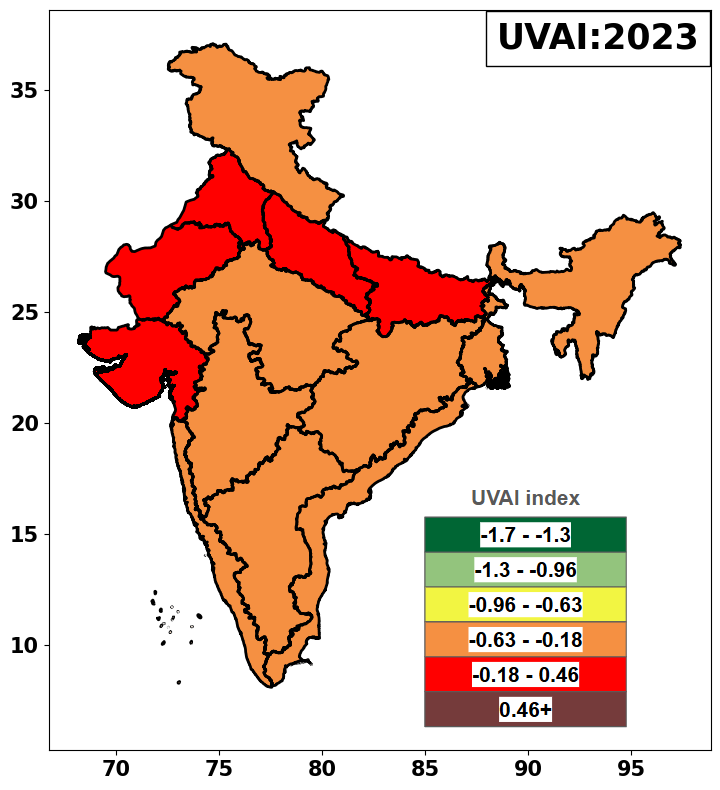

In [138]:
year = 2023
df_year = df[df.year==str(year)]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

colors = ['#274e13ff', #Dark Green
          '#93c47dff', # Light green
          '#f2f542ff', # Yellow
          '#f59042ff', # Orange
          '#ff0000ff', #Red
          '#753b3bff' #Dark Brown
          ]  # Define your colors
cmap_name = 'custom_cmap'
colors = [colors[i] for i in sorted(df_year['bin'].unique())]
# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=len(colors))
gdf.boundary.plot(ax=ax, linewidth=2, color='black')  # Adjust the boundary thickness here
gdf.merge(df_year, on='airshednum')[['bin','geometry']].plot(column = 'bin',
                                                                       ax=ax,
                                                                       cmap=custom_cmap,
                                                                      # legend=True,
                                                                      # vmin=df['no2'].min(),
                                                                      # vmax=df['no2'].max()
                                                                      )


#Add year - month annotation
bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=1)
plt.text(93.4, 37.3,
         '{}:{}'.format('UVAI',year),
         fontsize=25, fontweight='bold', color='black',
         ha='center', va='center',
             bbox=bbox_props)

plt.xticks(weight = 'bold', fontsize=15)
plt.yticks(weight = 'bold', fontsize=15)

# Add legend - custom image
legend_img = plt.imread(r"C:\Users\dskcy\UEInfo\TROPOMI_EXTRACTS\assets\regionalairshed_{}_legend.png".format('uvai'))  # Provide the path to your image file
plt.figimage(legend_img, xo=420, yo=60)

plt.tight_layout()
plt.savefig("regionalplots/{}_{}.png".format(pollutant,year))

In [52]:
df_year

pollutant,airshednum,o3,year,bin
4,1,0.000000,2023,1
9,2,0.000000,2023,1
14,3,0.000000,2023,1
19,4,0.000000,2023,1
24,5,0.000000,2023,1
29,6,0.000000,2023,1
34,7,0.000000,2023,1
39,8,0.005387,2023,3
44,9,0.002502,2023,2
49,10,0.012037,2023,5
